<a href="https://colab.research.google.com/github/nickklos10/SerieA_Machine_Learning_Predictions_2025/blob/main/Serie_A_ML_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
!pip install shap

In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import shap
import matplotlib.pyplot as plt

In [44]:
df = pd.read_csv('/content/final_merged_data_with_transfers.csv')
df.columns = df.columns.str.strip()
df.head()

,Stagione,Pos,Gio,Pti,Vit,Par,Sco,GolF,GolS,DR,...,Total Market Value,Players In,Players Out,Average Age IN players,Average Age OUT players,Market Value IN Players,Market Value OUT Players,Fees Players IN,Fees Players OUT,Net_Spent
0,2007-2008,10,38,48,13,9,16,44,52,-8,...,63250000,16,23,24.000000,25.304348,23375000,200000,23550000,10010000,-13540000
1,2008-2009,5,38,68,19,11,8,56,39,17,...,91700000,26,16,22.346154,25.500000,63575000,0,55860000,39800000,-16060000
2,2009-2010,9,38,51,14,9,15,57,61,-4,...,135850000,32,22,22.281250,25.590909,84500000,235000,78990000,67500000,-11490000
3,2010-2011,10,38,51,14,9,15,45,47,-2,...,168180000,26,29,22.807692,23.413793,77050000,1675000,73650000,57000000,-16650000
4,2011-2012,17,38,42,11,9,18,50,69,-19,...,104300000,24,32,24.208333,23.468750,70650000,10350000,52730000,77350000,24620000


In [45]:
target_variables = ['Pos', 'Pti', 'Vit', 'Par', 'Sco', 'GolF', 'GolS']

input_features = [
    'Squad Size', 'Average Age', 'Foreigners',
    'Average Market Value', 'Total Market Value', 'Players In', 'Players Out',
    'Average Age IN players', 'Average Age OUT players',
    'Market Value IN Players', 'Market Value OUT Players',
    'Fees Players IN', 'Fees Players OUT', 'Net_Spent'
]

In [46]:
log_features = ['Average Market Value', 'Total Market Value', 'Market Value IN Players',
                'Market Value OUT Players', 'Fees Players IN', 'Fees Players OUT', 'Net_Spent']
for feature in log_features:
    df[feature] = df[feature].clip(lower=0)
    df[f'{feature}_log'] = np.log1p(df[feature])
    input_features.append(f'{feature}_log')

In [47]:
le_team = LabelEncoder()
le_coach = LabelEncoder()

df['Team_Label'] = le_team.fit_transform(df['Team'])

df['Coach_Label'] = le_coach.fit_transform(df['Coach'])

print(df[['Team', 'Team_Label', 'Coach', 'Coach_Label']].head())

        Team  Team_Label                 Coach  Coach_Label
0  Genoa CFC           9  Gian Piero Gasperini           38
1  Genoa CFC           9  Gian Piero Gasperini           38
2  Genoa CFC           9  Gian Piero Gasperini           38
3  Genoa CFC           9     Davide Ballardini           21
4  Genoa CFC           9      Alberto Malesani            1


In [48]:
threshold = 7

similar_teams = df[df['Seasons'] <= threshold]


limited_teams_list = ['Como 1907', 'AC Monza']
limited_teams = df[df['Team'].isin(limited_teams_list)]


augmented_data = pd.concat([limited_teams, similar_teams])


augmented_data.reset_index(drop=True, inplace=True)


last_completed_year = 2023

train_data = df[df['Year'] <= last_completed_year]

train_data_limited = augmented_data[augmented_data['Year'] <= last_completed_year]

validation_data = df[df['Year'] == last_completed_year]

print(f"Training Data Shape: {train_data.shape}")
print(f"Training Data Limited Shape: {train_data_limited.shape}")
print(f"Validation Data Shape: {validation_data.shape}")

Training Data Shape: (282, 43)
Training Data Limited Shape: (284, 43)
Validation Data Shape: (17, 43)


In [49]:
scaler_input = StandardScaler()
scaler_target = StandardScaler()

scaler_input.fit(train_data[input_features])

scaler_target.fit(train_data[target_variables])

StandardScaler()

In [50]:
# Transform the features
X_train_main_numeric = scaler_input.transform(train_data[input_features])
X_val_main_numeric = scaler_input.transform(validation_data[input_features])
X_train_limited_numeric = scaler_input.transform(train_data_limited[input_features])

# Transform the target variables
y_train_main_scaled = scaler_target.transform(train_data[target_variables])
y_val_main_scaled = scaler_target.transform(validation_data[target_variables])
y_train_limited_scaled = scaler_target.transform(train_data_limited[target_variables])

In [51]:
# Replace NaN values in validation data after scaling
X_val_main_numeric = np.nan_to_num(X_val_main_numeric)
y_val_main_scaled = np.nan_to_num(y_val_main_scaled)

X_train_main_team = train_data['Team_Label'].values
X_train_main_coach = train_data['Coach_Label'].values
y_train_main = y_train_main_scaled

# Validation data
X_val_main_team = validation_data['Team_Label'].values
X_val_main_coach = validation_data['Coach_Label'].values
y_val_main = y_val_main_scaled

X_train_limited_team = train_data_limited['Team_Label'].values
X_train_limited_coach = train_data_limited['Coach_Label'].values
y_train_limited = y_train_limited_scaled

X_val_limited_numeric = X_val_main_numeric
X_val_limited_team = X_val_main_team
X_val_limited_coach = X_val_main_coach
y_val_limited = y_val_main

num_teams = df['Team_Label'].nunique()
num_coaches = df['Coach_Label'].nunique()

In [52]:
# Inputs
numeric_input = Input(shape=(len(input_features),), name='numeric_input')
team_input = Input(shape=(1,), name='team_input')
coach_input = Input(shape=(1,), name='coach_input')

# Embeddings
team_embedding = Embedding(input_dim=num_teams, output_dim=5, name='team_embedding')(team_input)
team_embedding = Flatten()(team_embedding)

coach_embedding = Embedding(input_dim=num_coaches, output_dim=5, name='coach_embedding')(coach_input)
coach_embedding = Flatten()(coach_embedding)

concatenated = Concatenate()([numeric_input, team_embedding, coach_embedding])

In [53]:
# Hidden Layers
x = Dense(128, activation='relu')(concatenated)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(len(target_variables), activation='linear', name='output')(x)


model_main = Model(inputs=[numeric_input, team_input, coach_input], outputs=output)
model_main.compile(optimizer='adam', loss='mse')


model_main.summary()

model_limited = Model(inputs=[numeric_input, team_input, coach_input], outputs=output)
model_limited.compile(optimizer='adam', loss='mse')

early_stop_main = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

early_stop_limited = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ team_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ coach_input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ team_embedding            │ (None, 1, 5)           │            100 │ team_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ coach_embedding           │ (None, 1, 5)           │            510 │ coach_input[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ numeric_input             │ (None, 21)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 5)              │              0 │ team_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 5)              │              0 │ coach_embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 31)             │              0 │ numeric_input[0][0],   │
│ (Concatenate)             │                        │                │ flatten_2[0][0],       │
│                           │                        │                │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │          4,096 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 64)             │          8,256 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 7)              │            455 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 13,417 (52.41 KB)

 Trainable params: 13,417 (52.41 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# Train the main model
history_main = model_main.fit(
    [X_train_main_numeric, X_train_main_team, X_train_main_coach],
    y_train_main,
    epochs=100,
    batch_size=32,
    validation_data=([X_val_main_numeric, X_val_main_team, X_val_main_coach], y_val_main),
    callbacks=[early_stop_main],
    verbose=1
)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 1.0516 - val_loss: 0.8722
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.9303 - val_loss: 0.7548
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.8374 - val_loss: 0.6900
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7369 - val_loss: 0.6411
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7854 - val_loss: 0.5844
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6647 - val_loss: 0.5566
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6177 - val_loss: 0.5421
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6357 - val_loss: 0.5130
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6107 - val_loss: 0.4854
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5894 - val_loss: 0.4715
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6002 - val_loss: 0.4619
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5763 - val_lo

In [55]:
# Train the limited teams model
history_limited = model_limited.fit(
    [X_train_limited_numeric, X_train_limited_team, X_train_limited_coach],
    y_train_limited,
    epochs=100,
    batch_size=32,
    validation_data=([X_val_limited_numeric, X_val_limited_team, X_val_limited_coach], y_val_limited),
    callbacks=[early_stop_limited],
    verbose=1
)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.2487 - val_loss: 0.1566
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2540 - val_loss: 0.1617
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2248 - val_loss: 0.1660
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2151 - val_loss: 0.1454
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2299 - val_loss: 0.1478
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2433 - val_loss: 0.1496
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2306 - val_loss: 0.1553
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2214 - val_loss: 0.1474
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2288 - val_loss: 0.1375
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2219 - val_loss: 0.1325
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2366 - val_loss: 0.1318
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2252 - val_lo

In [56]:
latest_data = df[df['Year'] == last_completed_year + 1].copy()

df_2025 = latest_data.copy()

df_2025['Year'] = last_completed_year + 2  # 2025

df_2025.drop(columns=target_variables + ['Pos'], inplace=True, errors='ignore')

df_2025 = df_2025.drop_duplicates(subset=['Team'], keep='last').reset_index(drop=True)

df_2025.head()

,Stagione,Gio,DR,Team,Year,Coach,Nationality,Matches,Seasons,Finals,...,Net_Spent,Average Market Value_log,Total Market Value_log,Market Value IN Players_log,Market Value OUT Players_log,Fees Players IN_log,Fees Players OUT_log,Net_Spent_log,Team_Label,Coach_Label
0,2024-2025,6,-6,Genoa CFC,2025,Alberto Gilardino,Italy,6,1,0,...,8790000,15.292560,18.727062,17.450462,17.409392,17.281246,17.523948,15.989125,9,0
1,2024-2025,6,0,ACF Fiorentina,2025,Raffaele Palladino,Italy,6,1,0,...,0,16.139857,19.397878,17.479072,17.445834,17.553180,16.683410,0.000000,2,80
2,2024-2025,6,-2,Bologna FC 1909,2025,Vincenzo Italiano,Italy,6,1,0,...,46350000,16.020483,19.454932,17.997561,18.496484,17.757092,18.398946,17.651732,5,97
3,2024-2025,6,-1,Hellas Verona,2025,Paolo Zanetti,Italy,6,1,0,...,6040000,14.608504,18.161910,16.755994,16.712803,16.594330,16.912897,15.613915,10,74
4,2024-2025,6,6,Inter Milan,2025,Simone Inzaghi,Italy,6,1,0,...,0,17.068208,20.326215,18.446105,17.076488,18.064006,16.195057,0.000000,11,90


In [57]:
new_teams = set(df_2025['Team']) - set(le_team.classes_)
if new_teams:
    print(f"New teams found: {new_teams}")
    le_team.classes_ = np.concatenate([le_team.classes_, list(new_teams)])
df_2025['Team_Label'] = le_team.transform(df_2025['Team'])

new_coaches = set(df_2025['Coach']) - set(le_coach.classes_)
if new_coaches:
    print(f"New coaches found: {new_coaches}")
    le_coach.classes_ = np.concatenate([le_coach.classes_, list(new_coaches)])
df_2025['Coach_Label'] = le_coach.transform(df_2025['Coach'])

In [58]:
df_2025.columns = df_2025.columns.str.strip()

for feature in log_features:
    df_2025[f'{feature}_log'] = np.log1p(df_2025[feature].clip(lower=0))

# Scale numerical features using input_features
X_2025_numeric = scaler_input.transform(df_2025[input_features])

# Replace NaN values in scaled features
X_2025_numeric = np.nan_to_num(X_2025_numeric)

# Prepare inputs
X_2025_team = df_2025['Team_Label'].values
X_2025_coach = df_2025['Coach_Label'].values

# Create masks
is_limited_team = df_2025['Team'].isin(limited_teams_list)

In [59]:
# Prepare inputs for regular teams
X_2025_numeric_regular = X_2025_numeric[~is_limited_team]
X_2025_team_regular = X_2025_team[~is_limited_team]
X_2025_coach_regular = X_2025_coach[~is_limited_team]

# Prepare inputs for limited teams
X_2025_numeric_limited = X_2025_numeric[is_limited_team]
X_2025_team_limited = X_2025_team[is_limited_team]
X_2025_coach_limited = X_2025_coach[is_limited_team]

# Predict for regular teams
predictions_regular_scaled = model_main.predict([
    X_2025_numeric_regular,
    X_2025_team_regular,
    X_2025_coach_regular
])

# Predict for limited teams
predictions_limited_scaled = model_limited.predict([
    X_2025_numeric_limited,
    X_2025_team_limited,
    X_2025_coach_limited
])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


In [60]:
# Inverse transform the scaled predictions
predictions_regular = scaler_target.inverse_transform(predictions_regular_scaled)
predictions_limited = scaler_target.inverse_transform(predictions_limited_scaled)

df_predictions_regular = df_2025[~is_limited_team].copy()
df_predictions_limited = df_2025[is_limited_team].copy()

df_predictions_regular[target_variables] = predictions_regular
df_predictions_limited[target_variables] = predictions_limited

df_predictions = pd.concat([df_predictions_regular, df_predictions_limited])

df_predictions['DR'] = df_predictions['GolF'] - df_predictions['GolS']

In [61]:
def safe_int_convert(x):
    if pd.isna(x) or np.isinf(x):
        return None
    else:
        return int(round(x))

for col in target_variables + ['DR']:
    df_predictions[col] = df_predictions[col].apply(safe_int_convert)

df_predictions = df_predictions.set_index('Team').loc[df_2025['Team']].reset_index()

df_sorted = df_predictions.dropna(subset=['Pti', 'DR'])
df_sorted = df_sorted.sort_values(by=['Pti', 'DR'], ascending=[False, False])

print(df_sorted[['Team', 'Pos', 'Pti', 'Vit', 'Par', 'Sco', 'GolF', 'GolS', 'DR']])

                 Team  Pos  Pti  Vit  Par  Sco  GolF  GolS  DR
4         Inter Milan    1   85   27    7    5    81    31  51
6          SSC Napoli    3   81   24    9    5    72    33  39
18           AC Milan    3   77   24    6    8    76    38  37
12        Atalanta BC    3   76   23    9    6    77    38  38
16        Juventus FC    5   70   20   13    5    60    32  28
11            AS Roma    4   70   20    9    9    66    40  26
2     Bologna FC 1909    6   64   18    9   11    64    47  18
17           SS Lazio    6   62   17    9   11    59    45  14
1      ACF Fiorentina    7   61   17   10   11    58    45  13
8           Torino FC    8   57   15   12   11    59    50   8
0           Genoa CFC    8   56   16   10   13    53    46   7
5            AC Monza   10   50   13    9   15    51    53  -2
14     Udinese Calcio   12   48   12   11   15    48    54  -6
13  Parma Calcio 1913   13   44   11   11   16    47    56  -9
3       Hellas Verona   14   42    9   13   16    38   

In [62]:
# Evaluate main model
y_pred_val_main_scaled = model_main.predict([X_val_main_numeric, X_val_main_team, X_val_main_coach])
y_pred_val_main = scaler_target.inverse_transform(y_pred_val_main_scaled)
y_val_main_original = scaler_target.inverse_transform(y_val_main)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


In [63]:
# Check for NaN values
nan_mask = ~np.isnan(y_val_main_original).any(axis=1) & ~np.isnan(y_pred_val_main).any(axis=1)

if np.sum(nan_mask) == 0:
    print("Error: All predictions or actual values are NaN. Unable to calculate metrics.")
else:
    y_val_main_original_filtered = y_val_main_original[nan_mask]
    y_pred_val_main_filtered = y_pred_val_main[nan_mask]

    # Calculate metrics
    mae_main = mean_absolute_error(y_val_main_original_filtered, y_pred_val_main_filtered)
    rmse_main = np.sqrt(mean_squared_error(y_val_main_original_filtered, y_pred_val_main_filtered))
    r2_main = r2_score(y_val_main_original_filtered, y_pred_val_main_filtered)

    print(f"Main Model - MAE: {mae_main:.2f}, RMSE: {rmse_main:.2f}, R²: {r2_main:.2f}")

    print(f"Number of samples used for evaluation: {np.sum(nan_mask)} out of {len(nan_mask)}")

Main Model - MAE: 1.78, RMSE: 2.75, R²: 0.93
Number of samples used for evaluation: 17 out of 17


In [64]:
# Evaluate limited teams model
y_pred_val_limited_scaled = model_limited.predict([X_val_limited_numeric, X_val_limited_team, X_val_limited_coach])
y_pred_val_limited = scaler_target.inverse_transform(y_pred_val_limited_scaled)
y_val_limited_original = scaler_target.inverse_transform(y_val_limited)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


In [65]:
# Check for NaN values
nan_mask_limited = ~np.isnan(y_val_limited_original).any(axis=1) & ~np.isnan(y_pred_val_limited).any(axis=1)

if np.sum(nan_mask_limited) == 0:
    print("Error: All predictions or actual values for limited teams are NaN. Unable to calculate metrics.")
else:
    y_val_limited_original_filtered = y_val_limited_original[nan_mask_limited]
    y_pred_val_limited_filtered = y_pred_val_limited[nan_mask_limited]

    # Calculate metrics
    mae_limited = mean_absolute_error(y_val_limited_original_filtered, y_pred_val_limited_filtered)
    rmse_limited = np.sqrt(mean_squared_error(y_val_limited_original_filtered, y_pred_val_limited_filtered))
    r2_limited = r2_score(y_val_limited_original_filtered, y_pred_val_limited_filtered)

    print(f"Limited Teams Model - MAE: {mae_limited:.2f}, RMSE: {rmse_limited:.2f}, R²: {r2_limited:.2f}")

    print(f"Number of samples used for evaluation (limited teams): {np.sum(nan_mask_limited)} out of {len(nan_mask_limited)}")

Limited Teams Model - MAE: 1.78, RMSE: 2.75, R²: 0.93
Number of samples used for evaluation (limited teams): 17 out of 17


In [66]:
selected_target = 'Pti'
selected_target_index = target_variables.index(selected_target)

def model_prediction_selected(X):
    team = np.zeros((X.shape[0], 1))
    coach = np.zeros((X.shape[0], 1))
    predictions = model_main([X, team, coach]).numpy()
    return predictions[:, selected_target_index]  # e.g., 'Pti'

# Initialize the SHAP explainer for the selected target
background_data = X_train_main_numeric[:100]
explainer = shap.KernelExplainer(model_prediction_selected, background_data)

In [67]:
X_val_main_numeric_clean = np.nan_to_num(X_val_main_numeric[:100])

shap_values = explainer.shap_values(X_val_main_numeric_clean)

  0%|          | 0/17 [00:00<?, ?it/s]

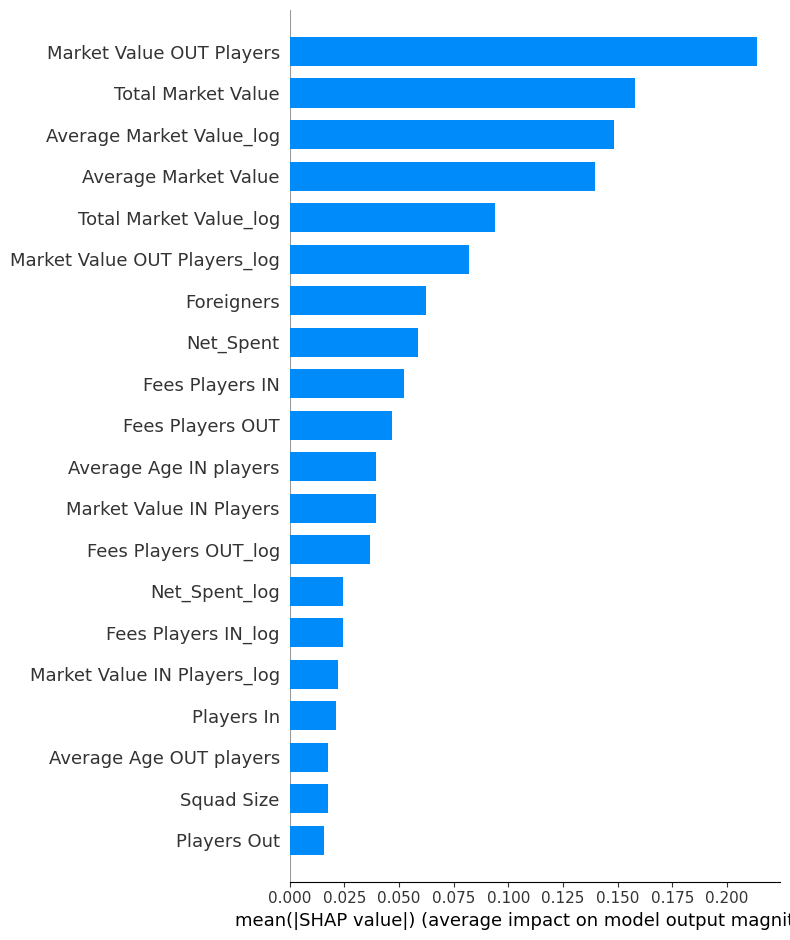

In [68]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_val_main_numeric_clean, plot_type="bar", feature_names=input_features)
plt.title(f"SHAP Feature Importance for {selected_target} (Main Model)")
plt.tight_layout()
plt.close()

<Figure size 1000x600 with 0 Axes>

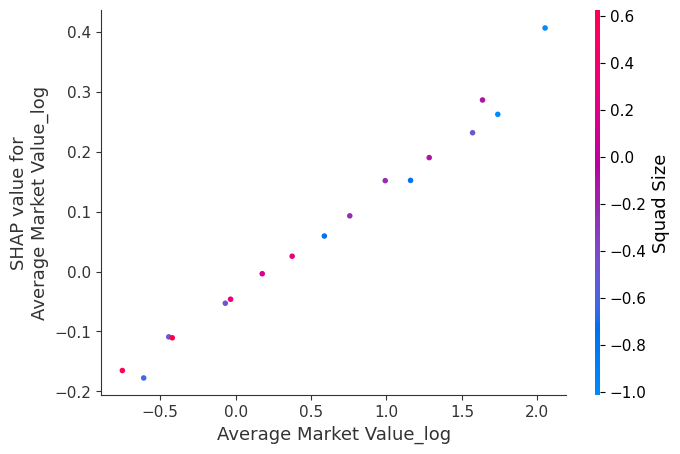

<Figure size 1000x600 with 0 Axes>

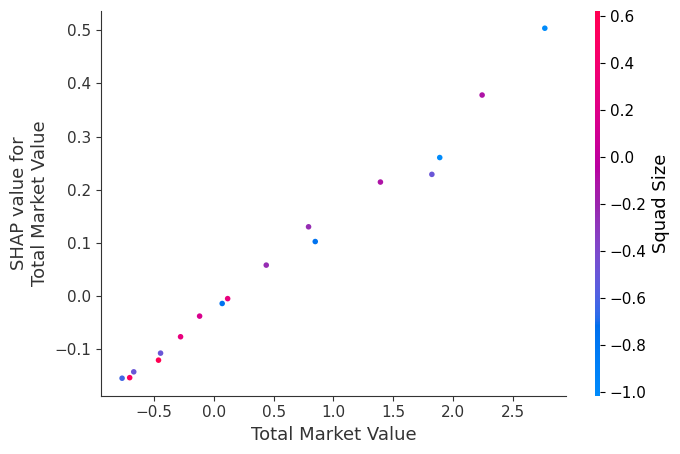

<Figure size 1000x600 with 0 Axes>

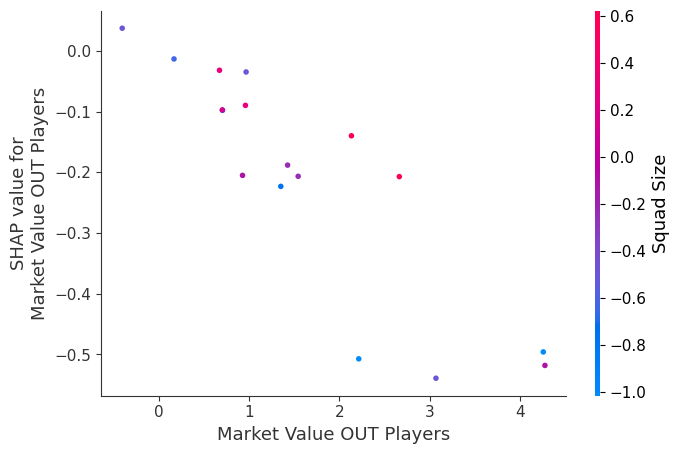

SHAP analysis completed.


In [69]:
mean_shap_values = np.abs(shap_values).mean(axis=0)
top_features_indices = np.argsort(mean_shap_values)[-3:]

for feature_idx in top_features_indices:
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(feature_idx, shap_values, X_val_main_numeric_clean, feature_names=input_features)
    plt.title(f"SHAP Dependence Plot for {input_features[feature_idx]} ({selected_target})")
    plt.tight_layout()
    plt.close()

print("SHAP analysis completed.")

In [70]:
# Feature importance based on SHAP values
feature_importance = np.abs(shap_values).mean(axis=0)
feature_importance_df = pd.DataFrame({'feature': input_features, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

print("\nFeature Importance based on SHAP values:")
print(feature_importance_df)


Feature Importance based on SHAP values:
                         feature  importance
10      Market Value OUT Players    0.213549
4             Total Market Value    0.158051
14      Average Market Value_log    0.148531
3           Average Market Value    0.139681
15        Total Market Value_log    0.093869
17  Market Value OUT Players_log    0.081873
2                     Foreigners    0.062150
13                     Net_Spent    0.058874
11               Fees Players IN    0.052415
12              Fees Players OUT    0.046927
7         Average Age IN players    0.039488
9        Market Value IN Players    0.039278
19          Fees Players OUT_log    0.036987
20                 Net_Spent_log    0.024381
18           Fees Players IN_log    0.024380
16   Market Value IN Players_log    0.022171
5                     Players In    0.021398
8        Average Age OUT players    0.017671
0                     Squad Size    0.017463
6                    Players Out    0.015907
1            

In [76]:
# Debugging: Check unique team names in df_predictions
print("Unique teams in df_predictions:")
print(df_predictions['Team'].unique())

present_teams = set(df_predictions['Team'])
missing_teams = set(teams_of_interest) - present_teams

print("\nTeams of interest present in df_predictions:")
print(set(teams_of_interest).intersection(present_teams))

print("\nTeams of interest missing in df_predictions:")
print(missing_teams)

Unique teams in df_predictions:
['Genoa CFC' 'ACF Fiorentina' 'Bologna FC 1909' 'Hellas Verona'
 'Inter Milan' 'AC Monza' 'SSC Napoli' 'Cagliari Calcio' 'Torino FC'
 'US Lecce' 'Empoli FC' 'AS Roma' 'Atalanta BC' 'Parma Calcio 1913'
 'Udinese Calcio' 'Venezia FC' 'Juventus FC' 'SS Lazio' 'AC Milan'
 'Como 1907']

Teams of interest present in df_predictions:
{'Inter Milan'}

Teams of interest missing in df_predictions:
{'As Roma', 'Ssc Napoli', 'Juventus Fc', 'Ac Milan'}


In [78]:
teams_of_interest = ['Inter Milan', 'AC Milan', 'Juventus FC', 'SSC Napoli', 'AS Roma', 'Atalanta BC']
predictions_of_interest = df_predictions[df_predictions['Team'].isin(teams_of_interest)]

print("\nPredictions for teams of interest:")
print(predictions_of_interest[['Team', 'Pos', 'Pti', 'Vit', 'Par', 'Sco', 'GolF', 'GolS', 'DR']])


Predictions for teams of interest:
           Team  Pos  Pti  Vit  Par  Sco  GolF  GolS  DR
4   Inter Milan    1   85   27    7    5    81    31  51
6    SSC Napoli    3   81   24    9    5    72    33  39
11      AS Roma    4   70   20    9    9    66    40  26
12  Atalanta BC    3   76   23    9    6    77    38  38
16  Juventus FC    5   70   20   13    5    60    32  28
18     AC Milan    3   77   24    6    8    76    38  37


In [72]:
top_4_avg_points = df_predictions['Pti'].nlargest(4).mean()
print(f"\nAverage predicted points for top 4 teams: {top_4_avg_points:.2f}")


Average predicted points for top 4 teams: 79.75


In [73]:
points_range = df_predictions['Pti'].max() - df_predictions['Pti'].min()
print(f"Predicted points range: {points_range:.2f}")

Predicted points range: 50.00


In [74]:
# Identify potential overachievers and underachievers
avg_points = df_predictions['Pti'].mean()
std_points = df_predictions['Pti'].std()

overachievers = df_predictions[df_predictions['Pti'] > avg_points + std_points]
underachievers = df_predictions[df_predictions['Pti'] < avg_points - std_points]

print("\nPotential overachievers:")
print(overachievers[['Team', 'Pti']])

print("\nPotential underachievers:")
print(underachievers[['Team', 'Pti']])


Potential overachievers:
           Team  Pti
4   Inter Milan   85
6    SSC Napoli   81
12  Atalanta BC   76
18     AC Milan   77

Potential underachievers:
               Team  Pti
7   Cagliari Calcio   35
9          US Lecce   39
10        Empoli FC   40
15       Venezia FC   40


In [75]:
df_predictions.to_csv('final_2025_predictions.csv', index=False)
print("\nFinal predictions saved to 'final_2025_predictions.csv'")

print("\nAnalysis complete!")


Final predictions saved to 'final_2025_predictions.csv'

Analysis complete!
